<a href="https://colab.research.google.com/github/erichan2046/EasyTrans/blob/master/train_mt5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers sentencepiece datasets

     |████████████████████████████████| 2.3MB 8.2MB/s 
     |████████████████████████████████| 1.2MB 48.1MB/s 
     |████████████████████████████████| 235kB 50.3MB/s 
     |████████████████████████████████| 3.3MB 51.2MB/s 
     |████████████████████████████████| 901kB 49.6MB/s 
     |████████████████████████████████| 112kB 52.4MB/s 
     |████████████████████████████████| 245kB 52.6MB/s 


In [ ]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook
sns.set()

/usr/local/lib/python3.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [ ]:
model_repo = 'google/mt5-small'

model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()
max_seq_len = model.config.max_length
tokenizer = AutoTokenizer.from_pretrained(model_repo)

In [ ]:
input_sents ='Presumed Guilty: Financial Watchdogs See Crypto as Illicit by Default'
token_ids = tokenizer.encode(input_sents,return_tensors='pt').cuda()


In [ ]:
model_out = model.generate(token_ids)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

<pad> <extra_id_0></s>


In [ ]:
example_input_str = '<jp>This is a test nbuig.'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[ 1042,  3889,   669, 13673,   339,   259,   262,  2978,   259,   272,
          1982,  1315,   260,     1]])
Tokens: ['▁<', 'jp', '>', 'This', '▁is', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>']


In [ ]:
dataset = load_dataset('alt')

No config specified, defaulting to: alt/alt-parallel


Dataset alt downloaded and prepared to /root/.cache/huggingface/datasets/alt/alt-parallel/1.0.0/e784a3f2a9f6bdf277940de6cc9d700eab852896cd94aad4233caf26008da9ed. Subsequent calls will reuse this data.


In [ ]:

train_dataset = dataset['train']
test_dataset = dataset['test']

In [ ]:
print(len(train_dataset))

18094


In [ ]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'ja': '<jp>',
    'zh': '<zh>'
}

In [ ]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250103, 512)

In [ ]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt',
    padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tensor([[250101,   1494,    339,    259,    262,   2978,    259,    272,   1982,
           1315,    260,      1,      0,      0,      0,      0,      0,      0,
              0,      0]])


In [ ]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]
  
def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)
  
  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)
  
  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)
    
    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
    
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [ ]:
in_ids, out_ids = format_translation_data(
    train_dataset[1]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<jp> ▁ 安 德里 亚 · 马 西 在 第四 分钟 成功 达 阵 , 意大利 率先 得分 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁ アンド レア ・ マー ジ が 開始 4 分 後の トライ で イタリア にとって 最初の 得点 を入れ た 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

In [ ]:
n_epochs = 5
batch_size = 16
print_freq = 50
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [ ]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

In [ ]:

losses = []
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
test_loss = eval_model(model, test_dataset)

In [ ]:
test_loss

24.820658683776855

In [ ]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  
  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):

    optimizer.zero_grad()
      
    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
      
  test_loss = eval_model(model, test_dataset)
  print('Test loss of {:.3f}'.format(test_loss))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch: 1 | Step: 50 | Avg. loss: 14.070 | lr: 0.00044642857142857147
Epoch: 1 | Step: 100 | Avg. loss: 6.436 | lr: 0.0004960707269155207
Epoch: 1 | Step: 150 | Avg. loss: 4.947 | lr: 0.0004916056438649759
Epoch: 1 | Step: 200 | Avg. loss: 4.531 | lr: 0.00048714056081443114
Epoch: 1 | Step: 250 | Avg. loss: 4.242 | lr: 0.0004826754777638864
Epoch: 1 | Step: 300 | Avg. loss: 4.117 | lr: 0.0004782103947133417
Epoch: 1 | Step: 350 | Avg. loss: 3.950 | lr: 0.00047374531166279694
Epoch: 1 | Step: 400 | Avg. loss: 3.781 | lr: 0.0004692802286122522
Epoch: 1 | Step: 450 | Avg. loss: 3.723 | lr: 0.0004648151455617075
Epoch: 1 | Step: 500 | Avg. loss: 3.726 | lr: 0.00046035006251116275
Epoch: 1 | Step: 550 | Avg. loss: 3.641 | lr: 0.00045588497946061796
Epoch: 1 | Step: 600 | Avg. loss: 3.585 | lr: 0.00045141989641007323
Epoch: 1 | Step: 650 | Avg. loss: 3.522 | lr: 0.0004469548133595285
Epoch: 1 | Step: 700 | Avg. loss: 3.539 | lr: 0.00044248973030898376
Epoch: 1 | Step: 750 | Avg. loss: 3.474 |

Epoch: 2 | Step: 50 | Avg. loss: 3.131 | lr: 0.00039953563136274335
Epoch: 2 | Step: 100 | Avg. loss: 3.150 | lr: 0.0003950705483121986
Epoch: 2 | Step: 150 | Avg. loss: 3.130 | lr: 0.00039060546526165383
Epoch: 2 | Step: 200 | Avg. loss: 3.100 | lr: 0.00038614038221110916
Epoch: 2 | Step: 250 | Avg. loss: 3.082 | lr: 0.00038167529916056437
Epoch: 2 | Step: 300 | Avg. loss: 3.131 | lr: 0.00037721021611001964
Epoch: 2 | Step: 350 | Avg. loss: 3.068 | lr: 0.00037274513305947496
Epoch: 2 | Step: 400 | Avg. loss: 3.115 | lr: 0.0003682800500089302
Epoch: 2 | Step: 450 | Avg. loss: 3.140 | lr: 0.00036381496695838544
Epoch: 2 | Step: 500 | Avg. loss: 3.017 | lr: 0.00035934988390784066
Epoch: 2 | Step: 550 | Avg. loss: 3.036 | lr: 0.000354884800857296
Epoch: 2 | Step: 600 | Avg. loss: 3.023 | lr: 0.0003504197178067512
Epoch: 2 | Step: 650 | Avg. loss: 3.043 | lr: 0.00034595463475620646
Epoch: 2 | Step: 700 | Avg. loss: 3.056 | lr: 0.00034148955170566173
Epoch: 2 | Step: 750 | Avg. loss: 3.037 

Epoch: 3 | Step: 50 | Avg. loss: 2.882 | lr: 0.0002985354527594213
Epoch: 3 | Step: 100 | Avg. loss: 2.829 | lr: 0.0002940703697088766
Epoch: 3 | Step: 150 | Avg. loss: 2.911 | lr: 0.00028960528665833185
Epoch: 3 | Step: 200 | Avg. loss: 2.850 | lr: 0.00028514020360778707
Epoch: 3 | Step: 250 | Avg. loss: 2.837 | lr: 0.0002806751205572424
Epoch: 3 | Step: 300 | Avg. loss: 2.796 | lr: 0.00027621003750669766
Epoch: 3 | Step: 350 | Avg. loss: 2.770 | lr: 0.00027174495445615287
Epoch: 3 | Step: 400 | Avg. loss: 2.831 | lr: 0.00026727987140560814
Epoch: 3 | Step: 450 | Avg. loss: 2.797 | lr: 0.0002628147883550634
Epoch: 3 | Step: 500 | Avg. loss: 2.840 | lr: 0.0002583497053045187
Epoch: 3 | Step: 550 | Avg. loss: 2.841 | lr: 0.0002538846222539739
Epoch: 3 | Step: 600 | Avg. loss: 2.729 | lr: 0.0002494195392034292
Epoch: 3 | Step: 650 | Avg. loss: 2.762 | lr: 0.0002449544561528844
Epoch: 3 | Step: 700 | Avg. loss: 2.787 | lr: 0.0002404893731023397
Epoch: 3 | Step: 750 | Avg. loss: 2.751 | lr

Epoch: 4 | Step: 50 | Avg. loss: 2.621 | lr: 0.0001975352741560993
Epoch: 4 | Step: 100 | Avg. loss: 2.667 | lr: 0.00019307019110555458
Epoch: 4 | Step: 150 | Avg. loss: 2.670 | lr: 0.00018860510805500982
Epoch: 4 | Step: 200 | Avg. loss: 2.645 | lr: 0.0001841400250044651
Epoch: 4 | Step: 250 | Avg. loss: 2.631 | lr: 0.00017967494195392033
Epoch: 4 | Step: 300 | Avg. loss: 2.652 | lr: 0.0001752098589033756
Epoch: 4 | Step: 350 | Avg. loss: 2.665 | lr: 0.00017074477585283086
Epoch: 4 | Step: 400 | Avg. loss: 2.659 | lr: 0.00016627969280228613
Epoch: 4 | Step: 450 | Avg. loss: 2.597 | lr: 0.0001618146097517414
Epoch: 4 | Step: 500 | Avg. loss: 2.601 | lr: 0.00015734952670119664
Epoch: 4 | Step: 550 | Avg. loss: 2.635 | lr: 0.0001528844436506519
Epoch: 4 | Step: 600 | Avg. loss: 2.620 | lr: 0.00014841936060010715
Epoch: 4 | Step: 650 | Avg. loss: 2.606 | lr: 0.00014395427754956242
Epoch: 4 | Step: 700 | Avg. loss: 2.577 | lr: 0.0001394891944990177
Epoch: 4 | Step: 750 | Avg. loss: 2.626 |

Epoch: 5 | Step: 50 | Avg. loss: 2.509 | lr: 9.653509555277729e-05
Epoch: 5 | Step: 100 | Avg. loss: 2.450 | lr: 9.207001250223254e-05
Epoch: 5 | Step: 150 | Avg. loss: 2.582 | lr: 8.76049294516878e-05
Epoch: 5 | Step: 200 | Avg. loss: 2.498 | lr: 8.313984640114307e-05
Epoch: 5 | Step: 250 | Avg. loss: 2.496 | lr: 7.867476335059832e-05
Epoch: 5 | Step: 300 | Avg. loss: 2.480 | lr: 7.420968030005358e-05
Epoch: 5 | Step: 350 | Avg. loss: 2.496 | lr: 6.974459724950884e-05
Epoch: 5 | Step: 400 | Avg. loss: 2.516 | lr: 6.527951419896411e-05
Epoch: 5 | Step: 450 | Avg. loss: 2.513 | lr: 6.0814431148419366e-05
Epoch: 5 | Step: 500 | Avg. loss: 2.541 | lr: 5.634934809787462e-05
Epoch: 5 | Step: 550 | Avg. loss: 2.467 | lr: 5.188426504732988e-05
Epoch: 5 | Step: 600 | Avg. loss: 2.473 | lr: 4.7419181996785136e-05
Epoch: 5 | Step: 650 | Avg. loss: 2.513 | lr: 4.2954098946240404e-05
Epoch: 5 | Step: 700 | Avg. loss: 2.524 | lr: 3.848901589569566e-05
Epoch: 5 | Step: 750 | Avg. loss: 2.523 | lr: 3

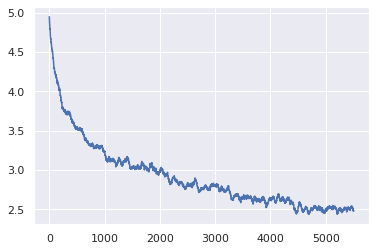

In [ ]:
window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [ ]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'ja',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.
Truncated input text: <jp> It has been confirmed that eight thoroughbred race horses at Randwick Racecourse</s>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

それは、クイーンズランド・レースコースの8匹の競泳選手8匹が
それは、クイーンズランド・レースコースの8匹の競泳選手に8匹
それは、クイーンズランド・レースコースの8匹の競泳選手8匹は


In [ ]:
input_text = 'how are you' #@param {type:"string"}
output_language = "zh" #@param ["en", "ja", "zh"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

how are you  ->  你为什么不这样做?
